<a href="https://colab.research.google.com/github/bjornlestrud/DS-Unit-2-Applied-Modeling/blob/master/Build_Week_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import Data

In [0]:
# install all necessary packages

%%capture
import sys

# If you're on Colab:
if 'google.colab' in sys.modules:
    DATA_PATH = 'https://raw.githubusercontent.com/LambdaSchool/DS-Unit-2-Applied-Modeling/master/data/'
    !pip install category_encoders==2.*
    !pip install pandas-profiling==2.*
    !pip install pdpbox
    !pip install shap
    !pip install category_encoders
    !pip install eli5

In [0]:
import pandas as pd

In [0]:
from google.colab import files
uploaded = files.upload()

Saving data.csv to data.csv


In [0]:
import io
df = pd.read_csv(io.BytesIO(uploaded['data.csv']))

# Clean Data

In [0]:
# wrangle function

def wrangle(X):

    X = X.copy()

    return X

    df = wrangle(df)

In [0]:
# price needs to be converted to a float or int

df['price'] = df['price'].str.replace('$', '')
df['price'] = df['price'].str.replace(',', '')
df['price'] = df['price'].astype(float)

In [0]:
# It reduces the MAE by excluding properties with exorbiant rent

df = df[df.price <= 200]
df = df[df.price >= 50]

In [0]:
df = df.drop(['Unnamed: 0'], axis=1)
df = df.drop(['accommodates'], axis = 1)
df = df.drop(['beds'], axis = 1)

In [0]:
df['price'].describe()

count    6237.000000
mean      113.744589
std        43.352150
min        50.000000
25%        79.000000
50%       100.000000
75%       149.000000
max       200.000000
Name: price, dtype: float64

In [0]:
df.columns

Index(['experiences_offered', 'host_response_time', 'host_response_rate',
       'host_neighbourhood', 'host_total_listings_count',
       'host_identity_verified', 'neighbourhood', 'neighbourhood_cleansed',
       'zipcode', 'latitude', 'longitude', 'property_type', 'room_type',
       'bathrooms', 'bedrooms', 'bed_type', 'amenities', 'price',
       'cleaning_fee', 'guests_included', 'minimum_nights', 'maximum_nights',
       'minimum_nights_avg_ntm', 'maximum_nights_avg_ntm', 'requires_license',
       'instant_bookable', 'is_business_travel_ready',
       'require_guest_profile_picture', 'require_guest_phone_verification',
       'calculated_host_listings_count',
       'calculated_host_listings_count_entire_homes',
       'calculated_host_listings_count_private_rooms',
       'calculated_host_listings_count_shared_rooms'],
      dtype='object')

In [0]:
df['price'].isnull().sum()

0

In [0]:
y = df['price']

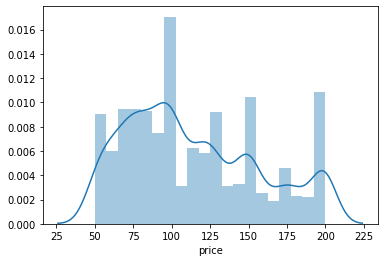

In [0]:
import seaborn as sns
sns.distplot(y);

# Get and Evaluate Mean Baseline

In [0]:
# do a 2 way split to get train/test

target = 'price'

from sklearn.model_selection import train_test_split
train, test = train_test_split(df, train_size=0.80, test_size=0.20, random_state=42)

train.shape, test.shape

((4989, 33), (1248, 33))

In [0]:
target = 'price'
y_train = train[target]
y_test = test[target]

In [0]:
print('Mean Baseline (using 0 features)')
guess = y_train.mean()

Mean Baseline (using 0 features)


In [0]:
# Train Error
from sklearn.metrics import mean_absolute_error
y_pred = [guess] * len(y_train)
mae = mean_absolute_error(y_train, y_pred)
print(f'Mean Baseline Train Error: {mae}')

Mean Baseline Train Error: 36.72919790144853


In [0]:
# Test Error
y_pred = [guess] * len(y_test)
mae = mean_absolute_error(y_test, y_pred)
print(f'Mean Baseline Test Error: {mae}')

Mean Baseline Test Error: 35.39969904944725


# Train, Fit and Evaluate a Ridge Regression Model

In [0]:
from sklearn.linear_model import Ridge
from sklearn.preprocessing import scale
from sklearn.metrics import mean_squared_error, make_scorer
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.feature_selection import f_regression, SelectKBest
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import OrdinalEncoder
import category_encoders as ce
from scipy.stats import randint, uniform
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

features = train.columns.drop(target)
X_train = train[features]
y_train = train[target]
X_test = test[features]
y_test = test[target]


In [0]:
pipeline = make_pipeline(
    ce.OrdinalEncoder(),
    SimpleImputer(),
    StandardScaler(),
    SelectKBest(f_regression),
    Ridge()
)

param_distributions = {
    'simpleimputer__strategy': ['mean', 'median'], 
    'selectkbest__k': range(1, len(X_train.columns)+1), 
    'ridge__alpha': [0.1, 1, 10], 
}


search = RandomizedSearchCV(
    pipeline, 
    param_distributions=param_distributions, 
    n_iter=10, 
    cv=5, 
    scoring='neg_mean_absolute_error', 
    verbose=10, 
    return_train_score=True, 
    n_jobs=-1
)

search.fit(X_train, y_train);

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 40 concurrent workers.
[Parallel(n_jobs=-1)]: Done   7 out of  50 | elapsed:    1.9s remaining:   11.8s
[Parallel(n_jobs=-1)]: Done  13 out of  50 | elapsed:    2.2s remaining:    6.3s
[Parallel(n_jobs=-1)]: Done  19 out of  50 | elapsed:    2.4s remaining:    3.8s
[Parallel(n_jobs=-1)]: Done  25 out of  50 | elapsed:    2.4s remaining:    2.4s
[Parallel(n_jobs=-1)]: Done  31 out of  50 | elapsed:    2.6s remaining:    1.6s
[Parallel(n_jobs=-1)]: Done  37 out of  50 | elapsed:    2.7s remaining:    1.0s
[Parallel(n_jobs=-1)]: Done  43 out of  50 | elapsed:    2.9s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    3.1s finished


In [0]:
print('Best hyperparameters', search.best_params_)
print('Cross-validation MAE', -search.best_score_)

Best hyperparameters {'simpleimputer__strategy': 'mean', 'selectkbest__k': 3, 'ridge__alpha': 0.1}
Cross-validation MAE 32.592630540068235


In [0]:
# Now to fit a ridge regression pipeline on the test set

pipeline = make_pipeline(
    ce.OrdinalEncoder(),
    SimpleImputer(),
    StandardScaler(),
    SelectKBest(f_regression),
    Ridge()
)

pipeline.fit(X_test, y_test)

Pipeline(memory=None,
         steps=[('ordinalencoder',
                 OrdinalEncoder(cols=['experiences_offered',
                                      'host_response_time',
                                      'host_response_rate',
                                      'host_neighbourhood',
                                      'host_identity_verified', 'neighbourhood',
                                      'zipcode', 'property_type', 'room_type',
                                      'bed_type', 'amenities', 'cleaning_fee',
                                      'requires_license', 'instant_bookable',
                                      'is_business_travel_ready',
                                      'require_guest_p...
                               missing_values=nan, strategy='mean',
                               verbose=0)),
                ('standardscaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('selectkbest',
      

In [0]:
y_pred = pipeline.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
print(f'Test MAE: ${mae:,.0f}')

Test MAE: $32


# Train, Fit and Evaluate a Random Forest Model

In [0]:
# let's encode a pipeline

features = train.columns.drop(target)
X_train = train[features]
y_train = train[target]
X_test = test[features]
y_test = test[target]

pipeline = make_pipeline(
    ce.OrdinalEncoder(), 
    SimpleImputer(), 
    RandomForestRegressor(n_estimators=100, n_jobs=-1, random_state=42)
)

param_distributions = {
    'simpleimputer__strategy': ['mean', 'median'], 
    'randomforestregressor__n_estimators': randint(50, 500), 
    'randomforestregressor__max_depth': [5, 10, 15, 20, None], 
    'randomforestregressor__max_features': uniform(0, 1), 
}

# If you're on Colab, decrease n_iter & cv parameters
search = RandomizedSearchCV(
    pipeline, 
    param_distributions=param_distributions, 
    n_iter=10, 
    cv=3, 
    scoring='neg_mean_absolute_error', 
    verbose=10, 
    return_train_score=True, 
    n_jobs=-1
)

search.fit(X_train, y_train);


Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 40 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of  30 | elapsed:    2.9s remaining:   26.2s
[Parallel(n_jobs=-1)]: Done   7 out of  30 | elapsed:    3.5s remaining:   11.4s
[Parallel(n_jobs=-1)]: Done  11 out of  30 | elapsed:    4.8s remaining:    8.3s
[Parallel(n_jobs=-1)]: Done  15 out of  30 | elapsed:    5.3s remaining:    5.3s
[Parallel(n_jobs=-1)]: Done  19 out of  30 | elapsed:    6.9s remaining:    4.0s
[Parallel(n_jobs=-1)]: Done  23 out of  30 | elapsed:    7.4s remaining:    2.2s
[Parallel(n_jobs=-1)]: Done  27 out of  30 | elapsed:    7.6s remaining:    0.8s
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    8.0s finished


In [0]:
print('Best hyperparameters', search.best_params_)
print('Cross-validation MAE', -search.best_score_)

Best hyperparameters {'randomforestregressor__max_depth': 15, 'randomforestregressor__max_features': 0.2598042259085618, 'randomforestregressor__n_estimators': 491, 'simpleimputer__strategy': 'median'}
Cross-validation MAE 29.680086737376882


In [0]:
pipeline = search.best_estimator_

In [0]:
y_pred = pipeline.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
print(f'Test MAE: ${mae}')

Test MAE: $29.25202305436995


In [0]:
pd.DataFrame(search.cv_results_).sort_values(by='rank_test_score').T

,4,6,0,1,9,8,2,5,3,7
mean_fit_time,5.45927,1.95443,1.45087,6.70714,6.013,3.1394,6.61284,1.35376,5.65826,2.89444
std_fit_time,0.114921,0.153493,0.0817432,0.0364129,0.0190764,0.224495,0.113915,0.00638293,0.203945,0.0956093
mean_score_time,0.482688,0.703228,0.499178,0.315633,0.265562,0.583028,0.295378,0.592222,0.402486,0.594676
std_score_time,0.0292065,0.0332656,0.00874811,0.0478179,0.0184834,0.0350656,0.0500654,0.0918672,0.0758175,0.051533
param_randomforestregressor__max_depth,15,None,15,None,10,10,20,5,20,10
param_randomforestregressor__max_features,0.259804,0.315553,0.411089,0.540215,0.752881,0.113804,0.879054,0.59899,0.980674,0.0151341
param_randomforestregressor__n_estimators,491,116,151,497,427,357,415,113,319,416
param_simpleimputer__strategy,median,mean,mean,median,median,median,mean,mean,mean,median
params,"{'randomforestregressor__max_depth': 15, 'rand...","{'randomforestregressor__max_depth': None, 'ra...","{'randomforestregressor__max_depth': 15, 'rand...","{'randomforestregressor__max_depth': None, 'ra...","{'randomforestregressor__max_depth': 10, 'rand...","{'randomforestregressor__max_depth': 10, 'rand...","{'randomforestregressor__max_depth': 20, 'rand...","{'randomforestregressor__max_depth': 5, 'rando...","{'randomforestregressor__max_depth': 20, 'rand...","{'randomforestregressor__max_depth': 10, 'rand..."
split0_test_score,-29.1574,-29.3187,-29.1721,-29.4928,-29.4354,-29.687,-29.9819,-30.4468,-29.9875,-30.9112


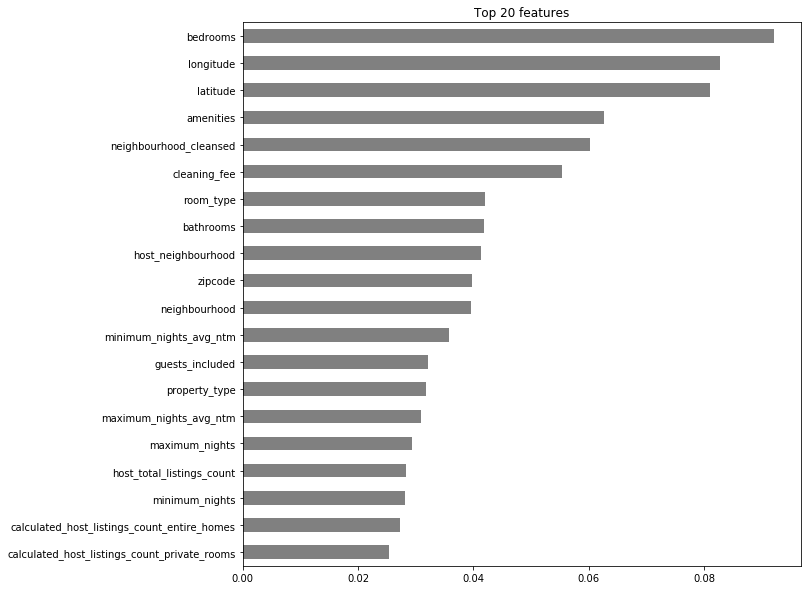

In [0]:
# Checking out the random forest regressor feature importances

rf = pipeline.named_steps['randomforestregressor']
importances = pd.Series(rf.feature_importances_, X_train.columns)

# Plot feature importances
%matplotlib inline
import matplotlib.pyplot as plt

n = 20
plt.figure(figsize=(10,n/2))
plt.title(f'Top {n} features')
importances.sort_values()[-n:].plot.barh(color='grey');


In [0]:
from sklearn.model_selection import train_test_split


train, val = train_test_split(train, train_size=0.80, test_size=0.20, 
                              random_state=42)

train.shape, val.shape, test.shape

((3991, 33), (998, 33), (1248, 33))

In [0]:
# doing a random forest regressor without a pipeline so i can see Feature Importances and PDP plots

train = train.dropna()
val = val.dropna()

X = train[features]
y = train[target]

# Use Ordinal Encoder, outside of a pipeline
encoder = ce.OrdinalEncoder()
X_encoded = encoder.fit_transform(X)

model = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
model.fit(X_encoded, y)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=-1, oob_score=False,
                      random_state=42, verbose=0, warm_start=False)

In [0]:
from pdpbox.pdp import pdp_interact, pdp_interact_plot
from pdpbox.pdp import pdp_isolate, pdp_plot
import matplotlib.pyplot as plt
plt.rcParams['figure.dpi'] = 72

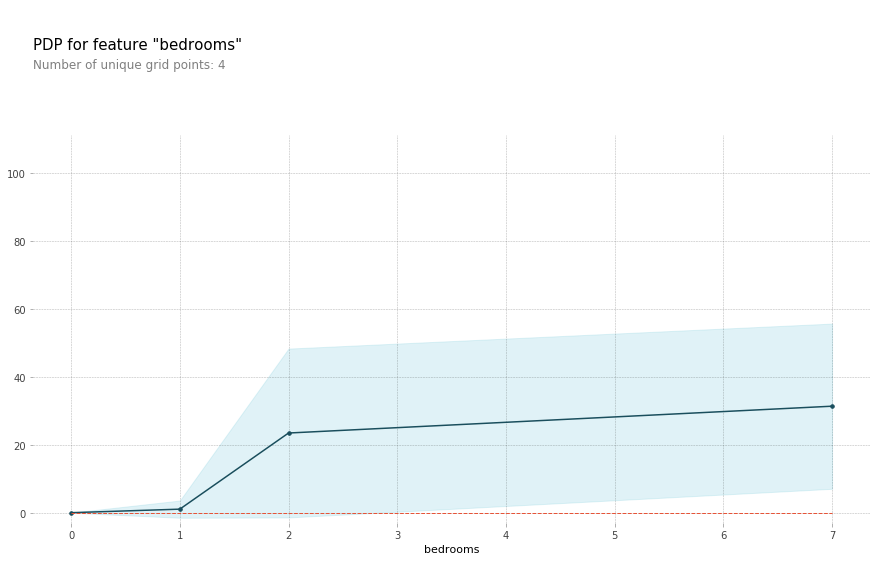

In [0]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams['figure.dpi'] = 72
from pdpbox import pdp
feature = 'bedrooms'
pdp_dist = pdp.pdp_isolate(model=model, dataset=X_encoded, model_features=features, feature=feature)
pdp.pdp_plot(pdp_dist, feature);

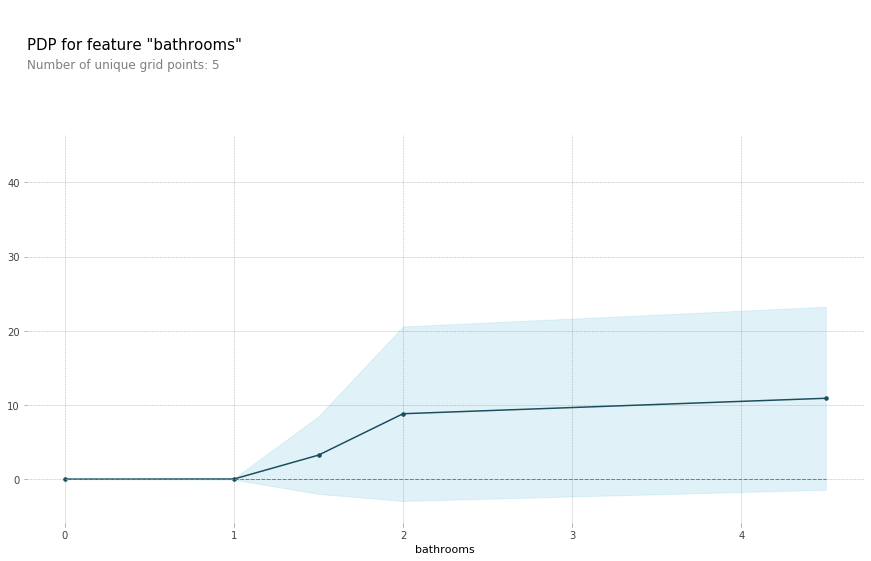

In [0]:
%matplotlib inline
import matplotlib.pyplot as plt
from pdpbox import pdp
feature = 'bathrooms'
pdp_dist = pdp.pdp_isolate(model=model, dataset=X_encoded, model_features=features, feature=feature)
pdp.pdp_plot(pdp_dist, feature);

In [0]:
from pdpbox.pdp import pdp_interact, pdp_interact_plot

features = ['bedrooms', 'bathrooms']

interaction = pdp_interact(
    model=model,
    dataset=X_encoded, 
    model_features=X_encoded.columns,
    features=features
)

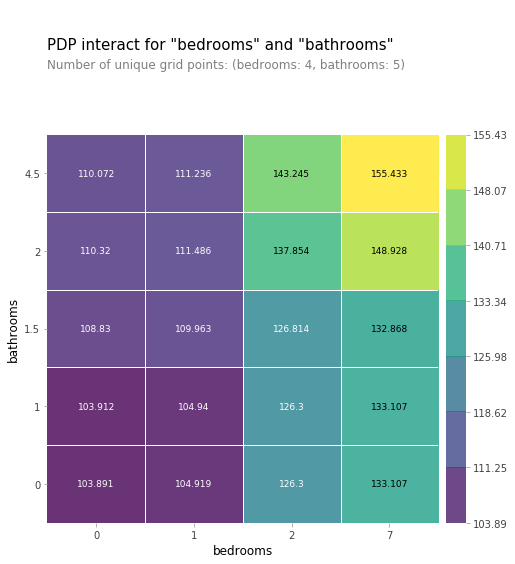

In [0]:
pdp_interact_plot(interaction, plot_type='grid',
                  feature_names=features);

In [0]:
# this works with the shapley exercise

X_val = val[features]
y_val = val[target]

transformers = make_pipeline(
    ce.OrdinalEncoder(),
    SimpleImputer(strategy='median')
)

X_train_transformed = transformers.fit_transform(X_encoded)

model = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
model.fit(X_encoded, y)


RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=-1, oob_score=False,
                      random_state=42, verbose=0, warm_start=False)

In [0]:
import shap

row = X_encoded.iloc[[1200]]

explainer = shap.TreeExplainer(model)
row_processed = transformers.transform(row)
shap_values = explainer.shap_values(row_processed)

shap.initjs()
shap.force_plot(
    base_value=explainer.expected_value, 
    shap_values=shap_values, 
    features=row, 
    link='logit'
)